# Music Taste Analysis

So I've gotten annoyed with people asking me what sort of music I like in the past. This notebook represents my effort to once and for all answer the question, because, yes, I regard it to be this complicated.

### How to Use

My first pass at this depended upon [Watsonbox's Exportify](https://github.com/watsonbox/exportify), but I decided I didn't like his version because of bugs and inadequate output detail. So I [went and forked it](https://github.com/pavelkomarov/exportify), cleaned up [the](https://github.com/pavelkomarov/exportify/blob/master/app.html) [code](https://github.com/pavelkomarov/exportify/blob/master/exportify.js), and [hosted it](https://pavelkomarov.com/exportify/app) myself.

As such, the code here depends on `.csv` inputs in the format output by [my version](https://pavelkomarov.com/exportify/app).
1. To get started, hop on over there, sign in to Spotify to give the app access to your playlists, and export whatever you like.
2. Next, download this `.ipynb` file, put it in the same place as the `.csv` you just downloaded.
3. Open a terminal in that directory, `python3 -m notebook`, and open the `.ipynb`.
4. Update the `filename` variable in the first code cell to point to your playlist instead, and `shift+enter` in each following code cell to generate the corresponding plot. (Or go straight to the bottom and select `Cell` -> `Run All Above` to get everything at once.)

### Read the Data

For years I've been accumulating my favorite songs in a single master playlist called `music that tickles my fancy`. As of writing it is more than 2600 very thoroughly-vetted songs. This is what I'll be analyzing. Let's take a look at the first few rows to get a sense of what we're dealing with.

In [1]:
filename = 'music_that_tickles_my_fancy.csv'

from matplotlib import pyplot
import pandas
from collections import defaultdict
from scipy.stats import pareto, gamma
from datetime import date

# read the data
data = pandas.read_csv(filename)
print("total songs:", data.shape[0])
print(data[:3])

total songs: 2643
                            Spotify URI                  Track Name  \
0  spotify:track:3T9HSgS5jBFdXIBPav51gj  Fanfare for the Common Man   
1  spotify:track:2bdZDXDoFLzazaomjzoER8            Highschool Lover   
2  spotify:track:1fE3ddAlmjJ99IIfLgZjTy             I Need a Dollar   

                                          Album Name  Duration (ms)  \
0  Copland Conducts Copland - Expanded Edition (F...         196466   
1                                    Virgin Suicides         162093   
2                                    I Need A Dollar         244373   

   Popularity Release Date                           Artist Name(s)  \
0          38         1963  Aaron Copland,London Symphony Orchestra   
1           0         2000                                      Air   
2           3   2010-03-16                               Aloe Blacc   

               Added By              Added At  \
0  spotify:user:pvlkmrv  2014-12-28T00:57:17Z   
1  spotify:user:pvlkmrv  2014

### Artist Bar Chart

Number of songs binned by artist. 

number of unique artists: 1093


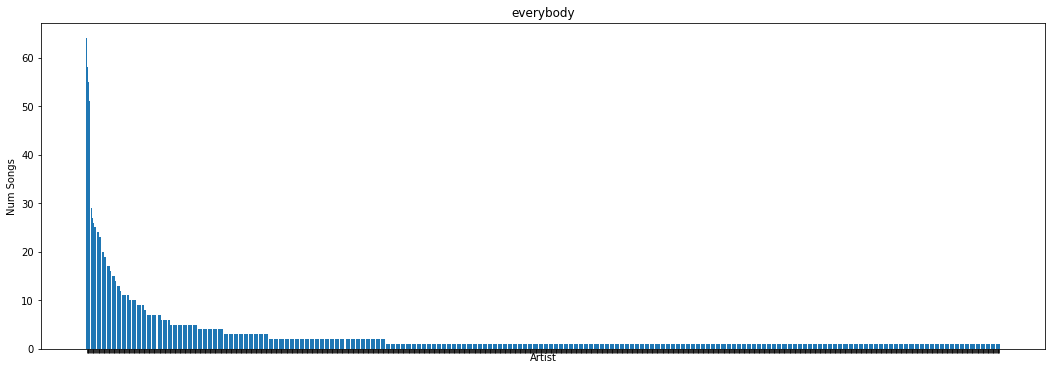

In [2]:
# count songs per artist
artists = defaultdict(int)
for i,song in data.iterrows():
	for musician in song['Artist Name(s)'].split(','):
		artists[musician] += 1

# sort for histogram
artists = pandas.DataFrame(artists.items(), columns=['Artist', 'Num Songs']
                          ).sort_values('Num Songs', ascending=False).reset_index(drop=True)
print("number of unique artists:", artists.shape[0])

pyplot.figure(figsize=(18, 6))
pyplot.bar(artists['Artist'], artists['Num Songs'])
pyplot.xticks(visible=False)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title('everybody')
pyplot.show()

Note I've attributed songs with multiple artists to multiple bars, so the integral here is the number of unique song-artist pairs, not just the number of songs.

It seems to follow a Pareto distribution. Let's try to fit one.

/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1682: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


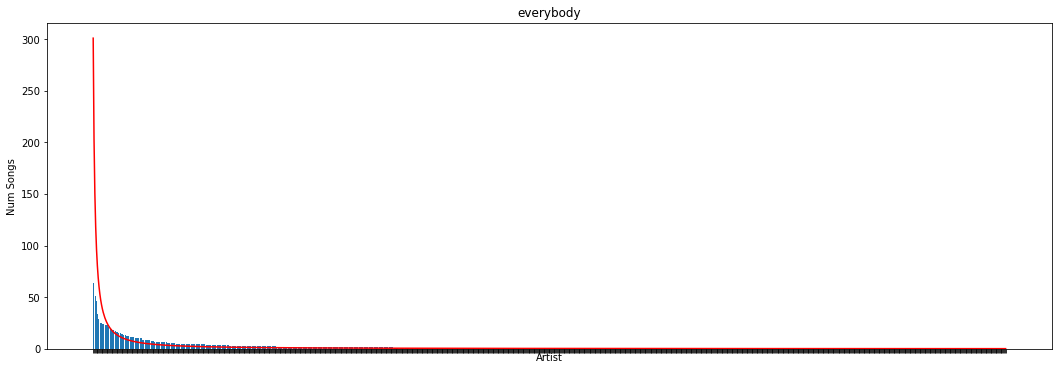

In [3]:
# Let's find the best parameters. Need x, y data 'sampled' from the distribution for
# parameter fit.
y = []
for i in range(artists.shape[0]):
	for j in range(artists['Num Songs'][i]):
		y.append(i) # just let y have histogram_index[artist] repeated for each song 

# sanity check. If the dataframe isn't sorted properly, y isn't either.
#pyplot.figure()
#pyplot.hist(y, bins=30)
        
# The documentation is pretty bad, but this is okay:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-
# ones-with-scipy-python
param = pareto.fit(y, 100)
pareto_fitted = len(y)*pareto.pdf(range(artists.shape[0]), *param)
# param = gamma.fit(y) # gamma fits abysmally; see for yourself by uncommenting
# gamma_fitted = len(y)*gamma.pdf(range(artists.shape[0]), *param)

pyplot.figure(figsize=(18, 6))
pyplot.bar(artists['Artist'], artists['Num Songs'])
pyplot.plot(pareto_fitted, color='r')
#pyplot.plot(gamma_fitted, color='g')
pyplot.xticks(visible=False)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title('everybody');

Best fit is still too sharp for the data, and I tried for a good long while to get it to fit better, so I conclude this doesn't *quite* fit a power law.

Let's plot the top 50 artists so we can actually read who they are.

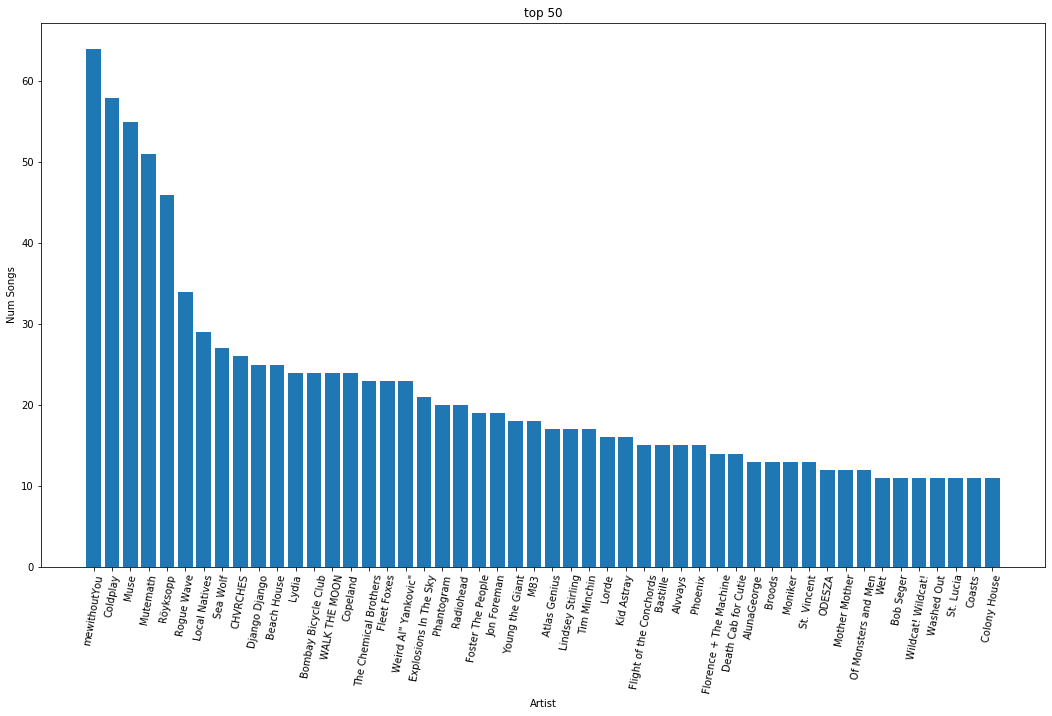

In [4]:
pyplot.figure(figsize=(18, 10))
pyplot.bar(artists['Artist'][:50], artists['Num Songs'][:50])
pyplot.xticks(rotation=80)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title('top 50');

### Volume Added Over Time

My proclivity to add songs to this playlist is a proxy for my interest in listening to music generally. How has it waxed and waned over time?

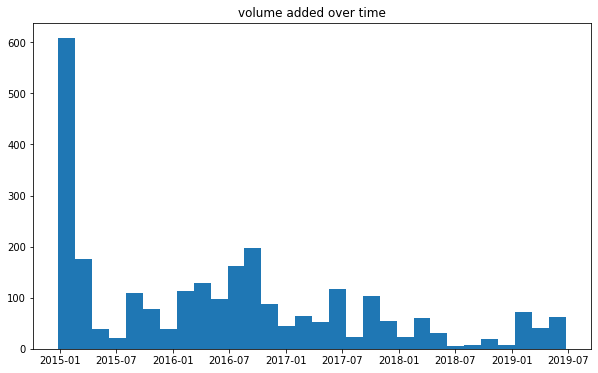

In [5]:
import pandas.plotting._converter as pandacnv
pandacnv.register() # to suppress warning

# Plot of added volume over time
parse_date = lambda d:(int(d[:4]), int(d[5:7]), int(d[8:10]))
pyplot.figure(figsize=(10, 6))
pyplot.hist([date(*parse_date(d)) for d in data['Added At']], bins=30)
pyplot.title('volume added over time');

The initial spike is from when I first stared using Spotify as the home for this collection and manually added hundreds from my previous list.

### Eclecticness Measure (Frequency Transform)

This one is a personal favorite. I want to know how many of my songs are one-offs from that artist for me--just individual pieces I found fantastic and ended up adding after a few listens--, how many are two-offs, et cetera. I know it must be heavily skewed toward the low numbers.

number of song-artist pairs represented in the eclecticness histogram: 2935


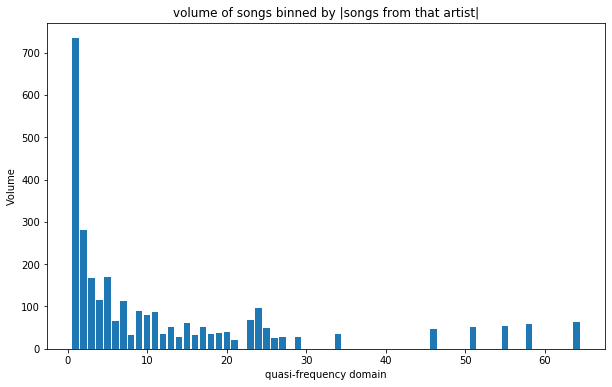

In [6]:
# histogram of the first histogram == hipster diversity factor
frequency = defaultdict(int)
for n in artists['Num Songs']:
	frequency[n] += n
frequency = pandas.DataFrame(frequency.items(), columns=['Unique Count', 'Volume']
                           ).sort_values('Volume', ascending=False)
print("number of song-artist pairs represented in the eclecticness histogram:",
      sum(frequency['Volume']))

pyplot.figure(figsize=(10, 6))
pyplot.bar(frequency['Unique Count'].values, frequency['Volume'].values)
pyplot.title('volume of songs binned by |songs from that artist|')
pyplot.xlabel('quasi-frequency domain')
pyplot.ylabel(frequency.columns[1]);

So, yes, it's much more common for an artist to make it in my list a few times than many times. In fact, the plurality of my top songs come from unique artists.

Conversely, this view also makes stark those few musicians from whom I've collected dozens.

Note that here, as in the artist bar charts, some songs are doubly-counted, because in cases artists collaborated I listed the song in both bins.

### Genres Bar Chart

Alright, enough messing around. All the above were possible with the output from Watsonbox's Exportify. Let's get to the novel stuff you came *here* for.

People describe music by genre. As we'll see, genre names are flippin' hilarious and extremely varied, but in theory if I cluster around a few, that should give you a flavor of my tastes.

number of unique genres: 663


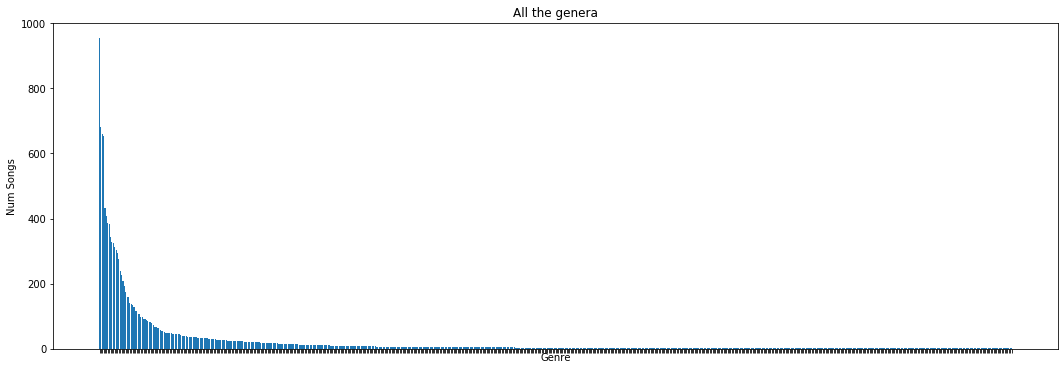

In [7]:
# count songs per genre
genres = defaultdict(int)
for i,song in data.iterrows():
    if type(song['Genres']) is str: # some times there aren't any, and this is NaN
        for genre in song['Genres'].split(','):
            if len(genre) > 0: # empty string seems to be a legit genre
                genres[genre] += 1

# sort for histogram
genres = pandas.DataFrame(genres.items(), columns=['Genre', 'Num Songs']
                          ).sort_values('Num Songs', ascending=False).reset_index(drop=True)
print("number of unique genres:", genres.shape[0])

pyplot.figure(figsize=(18, 6))
pyplot.bar(genres['Genre'], genres['Num Songs'])
pyplot.xticks(visible=False)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title('All the genera');

So many! Let's do the same thing as with the artists and for giggles see if it fits a power law.

/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


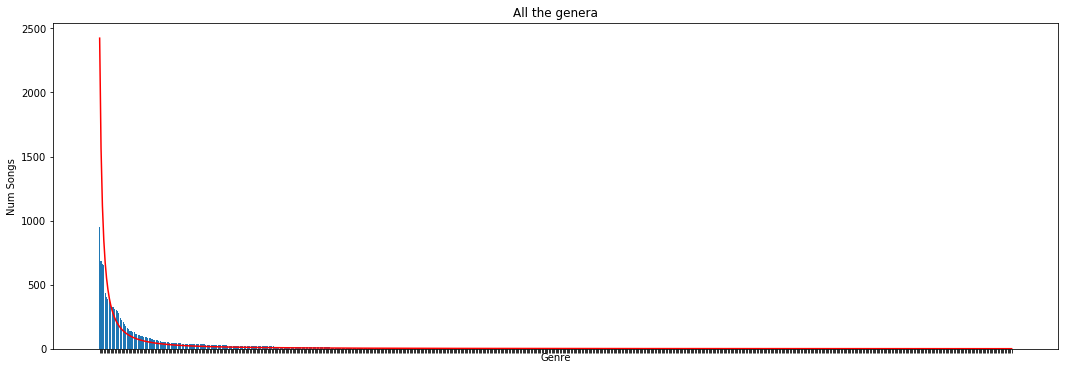

In [8]:
y = []
for i in range(genres.shape[0]):
	for j in range(genres['Num Songs'][i]):
		y.append(i) 

# sanity check
#pyplot.figure()
#pyplot.hist(y, bins=30)

param = pareto.fit(y, 100)
pareto_fitted = len(y)*pareto.pdf(range(genres.shape[0]), *param)

pyplot.figure(figsize=(18, 6))
pyplot.bar(genres['Genre'], genres['Num Songs'])
pyplot.plot(pareto_fitted, color='r')
pyplot.xticks(visible=False)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title('All the genera');

Still too sharp, but fits better than with the artists.

Let's look at the top 50 so we can read the names.

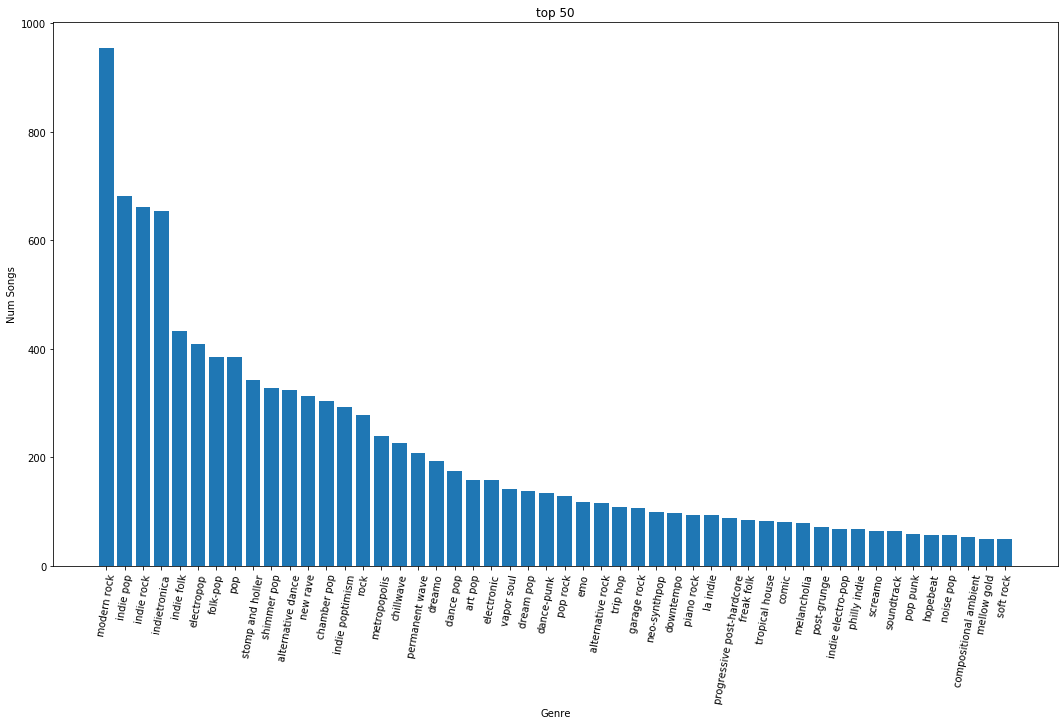

In [9]:
pyplot.figure(figsize=(18, 10))
pyplot.bar(genres['Genre'][:50], genres['Num Songs'][:50])
pyplot.xticks(rotation=80)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title('top 50');

"Indie poptimism" lol. wtf? "Dreamo", "Vapor soul", "Freak folk", "Tropical house", "Post-grunge", "Hopebeat", "Noise pop", "Mellow gold"

These are too good. Next time someone asks me my music taste, I'm definitely using these.

If these are the *most* popular names, what are the really unique ones at the bottom of the chart?

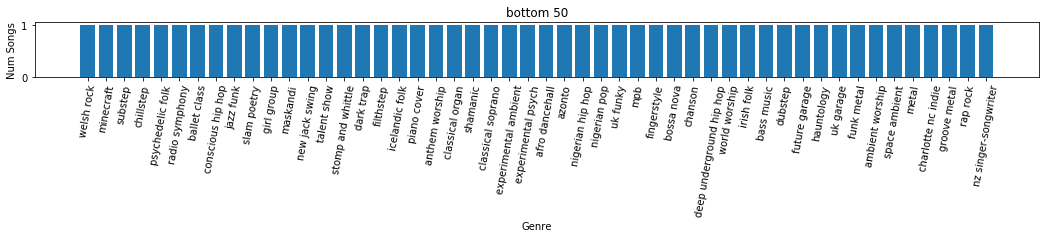

In [10]:
pyplot.figure(figsize=(18, 1))
pyplot.bar(genres['Genre'][-50:], genres['Num Songs'][-50:])
pyplot.xticks(rotation=80)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title('bottom 50');

"hauntology", "psychadelic folk", "stomp and whittle", "dark trap", "filthstep", "shamanic", "deep underground hip hop", "future garage"

That was fun.

### Release Dates

Which era of music do I prefer?

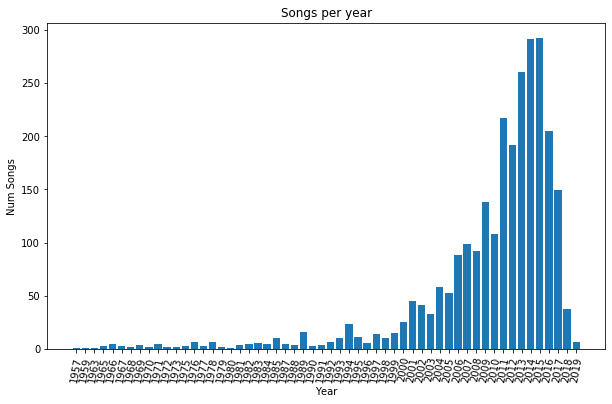

In [11]:
years = defaultdict(int)
for i,song in data.iterrows():
    years[song['Release Date'][:4]] += 1

years = pandas.DataFrame(years.items(), columns=['Year', 'Num Songs']
                          ).sort_values('Year')

pyplot.figure(figsize=(10, 6))
pyplot.bar(years['Year'], years['Num Songs'])
pyplot.xticks(rotation=80)
pyplot.xlabel(years.columns[0])
pyplot.ylabel(years.columns[1])
pyplot.title('Songs per year');

It seems to follow a Gamma distribution! This makes sense because I'm more likely to have heard things that are nearer me in time, and it takes a while for them to get through my process and become favorites.

Let's fit that gamma to the time-reversed data.

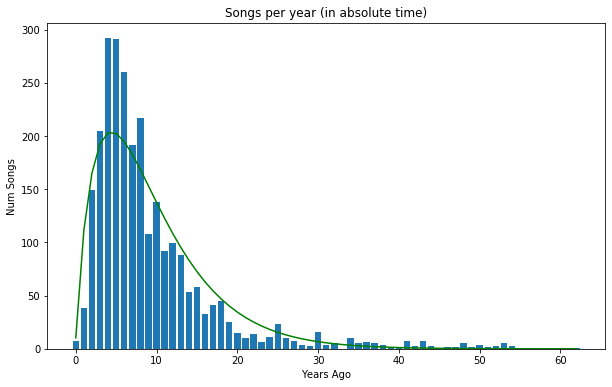

In [12]:
# Some years are missing, so transform to a dataframe that covers full time period.
eldest = int(years['Year'].values[0])
youngest = int(years['Year'].values[-1])
missing_years = [str(x) for x in range(eldest+1, youngest) if
                 str(x) not in years['Year'].values]
ago = years.append(pandas.DataFrame.from_dict(
    {'Year': missing_years, 'Num Songs': [0 for x in range(len(missing_years))]})
                  ).sort_values('Year', ascending=False).reset_index(drop=True)

y = []
for i in range(ago.shape[0]):
	for j in range(ago['Num Songs'][i]):
		y.append(i)

# sanity check histogram to make sure I'm constructing y properly
#pyplot.figure()
#pyplot.hist(y, bins=30)
        
param = gamma.fit(y)
gamma_fitted = len(y)*gamma.pdf(range(ago.shape[0]), *param)

pyplot.figure(figsize=(10, 6))
pyplot.bar(range(len(ago['Year'])), ago['Num Songs'])
pyplot.plot(gamma_fitted, color='g')
pyplot.xlabel('Years Ago')
pyplot.ylabel(ago.columns[1])
pyplot.title('Songs per year (in absolute time)');

Pretty good fit! I seem to be extra partial to music from about 5 years ago. We'll see whether the present or maybe the further past catches up.

### Track Duration

Do I prefer long songs or short ones?

Average song length: 4:05.671802118804379
Median song length: 3:55.02600000000001


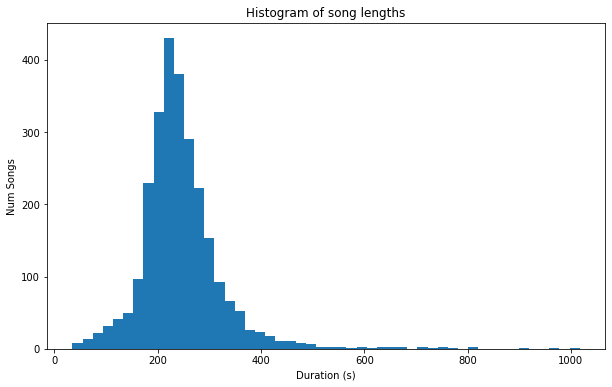

In [13]:
pyplot.figure(figsize=(10,6))
pyplot.hist(data['Duration (ms)']/1000, bins=50);
pyplot.xlabel('Duration (s)')
pyplot.ylabel('Num Songs')
pyplot.title('Histogram of song lengths')

mean = data['Duration (ms)'].mean()/1000
median = data['Duration (ms)'].median()/1000
print("Average song length: " + str(int(mean//60)) + (":" if mean%60 >=10 else ":0")
      + str(mean%60))
print("Median song length: " + str(int(median//60)) + (":" if median%60 >=10 else ":0")
      + str(median%60))

Median is lower than the mean, so I'm skewed right. That is, I like a few really long songs. What are they?

In [14]:
print("Longest Hall of Fame:")
print(data[['Track Name', 'Artist Name(s)', 'Release Date', 'Duration (ms)']].sort_values(
    'Duration (ms)', ascending=False)[:10])

Longest Hall of Fame:
                                             Track Name  \
709                                               Irene   
1961  The Return of the King (From The Lord of the R...   
465                                   The Cure For Pain   
2425              Shine On You Crazy Diamond (Pts. 1-5)   
143   Two Step - Live At Piedmont Park, Atlanta, GA ...   
1479                                          Cage-Nerd   
2426              Shine On You Crazy Diamond (Pts. 6-9)   
145   Warehouse - Live At Piedmont Park, Atlanta, GA...   
144   Don't Drink the Water - Live At Piedmont Park,...   
187   With Tired Eyes, Tired Minds, Tired Souls, We ...   

                                 Artist Name(s) Release Date  Duration (ms)  
709                                 Beach House   2012-05-15        1017013  
1961  The City of Prague Philharmonic Orchestra   2004-01-01         976893  
465                                mewithoutYou   2002-01-01         908840  
2425            

### Popularity Contest

I was happy to find popularity listed as a field in Spotify's track JSON. It's just a number between 0 and about 85, a relative measure, rather than an absolute number of plays. Still, it can be used to give a notion of how hipster I am.

Average song popularity:  41.5
Median song popularity:  41.5
Max song popularity:  83


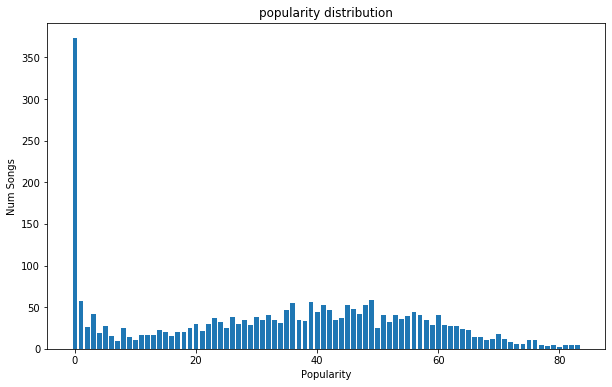

In [15]:
popularity = defaultdict(int)
for i,song in data.iterrows():
    popularity[song['Popularity']] += 1

popularity = pandas.DataFrame(popularity.items(), columns=['Popularity', 'Num Songs']
                          ).sort_values('Popularity')

pyplot.figure(figsize=(10, 6))
pyplot.bar(popularity['Popularity'].values, popularity['Num Songs'].values)
pyplot.xlabel(popularity.columns[0])
pyplot.ylabel(popularity.columns[1])
pyplot.title('popularity distribution');

print("Average song popularity: ", popularity['Popularity'].mean())
print("Median song popularity: ", popularity['Popularity'].median())
print("Max song popularity: ", popularity['Popularity'].max())

Damn, I'm a hipster.